In [5]:
%matplotlib inline
import sys
#sys.path.insert(0, '/home/space/kai/src/Viscid/')
#sys.path.insert(0, '/home/space/dominic/Viscid')

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import viscid
from viscid.plot import vpyplot as vlt
import h5py
import pandas as pd
import os
from mpl_toolkits import mplot3d

viscid.calculator.evaluator.enabled = True

%config InlineBackend.figure_format = 'retina'


project_dir="../harris_m100"
run = project_dir + "/pfd.xdmf"


#from scipy.signal import savgol_filter


In [6]:
# Convenient plotting function 
def make_plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(14,4*len(fldnames)))
    if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):
        # Hack around some inconsistencies with the field naming
        if run.endswith(".vpc"):
            map = {
                "bx_fc": "Magnetic Field X",
                "by_fc": "Magnetic Field Y",
                "bz_fc": "Magnetic Field Z",
                "jx": "Free Current Field X",
                "jy": "Free Current Field Y",
                "jz": "Free Current Field Z",
                "rho_nc": "Charge Density",
                "qn_nc_e": "Charge Density (ehydro)",
                "qn_nc_i": "Charge Density (Hhydro)",
                "jy_nc_e": "Current Density (ehydro) Y",
            }
        else:
            map = {
                "bx_fc": "hx_fc",
                "by_fc": "hy_fc",
                "bz_fc": "hz_fc",
                "qn_nc_e": "rho_nc_e",
                "qn_nc_i": "rho_nc_i",
            }
        #vf = viscid.load_file(run, force_reload=True)
        #vf.activate_time(time)
        #_fldname = map[fldname] if fldname in map else fldname
        #vlt.plot(vf[_fldname], ax=ax[i], **kwargs);
        
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        _fldname = map[fldname] if fldname in map else fldname
        mid_val = 0
        
        vlt.plot(vf[_fldname], ax=ax[i], **kwargs);
        #plt.scatter(knots[0], knots[2], color = 'k')
        #vlt.plot(vf["psi"],style="contour",levels=80,colors='k', ax=ax[i], **kwargs);

        
        

In [7]:
# Choose the directory and pfd file for the run you're using 
run = project_dir + "/pfd.xdmf"

# I honestly forget why this is here
pt = np.array([0, 5, 350])

# Change based on which run you're using
xl = np.array([0,-5,-100]) #where are these values for harris_run?  For now I've assumed theyre half the domain (except x)
xh = xl + np.array([800,10,200])
gdims = np.array([5120,1,1280])
dx = (xh - xl) / gdims






#gdims = np.array([idx_begin.shape[3], idx_begin.shape[2], idx_begin.shape[1]])


In [8]:
# Plot setup
vf = viscid.load_file(run, force_reload=True)
vf.activate_time(20)
fig, ax = plt.subplots(figsize=(12, 5))
vlt.plot(vf["ej = jx_nc_e*ex_ec + jy_nc_e*ey_ec + jz_nc_e*ez_ec"],selection="x=300f:450f, z=-30f:30f",
symmetric=True, ax=ax, cmap='seismic')
ax.set_aspect("equal")

         correct?


AttributeError: 'NoneType' object has no attribute 'activate_time'

In [6]:
import numpy as np
from scipy.stats import gaussian_kde

# random 2d values
X = np.random.randn(1000, 2)

# fit kernel density estimate. needs to be transposed for the function
kde = gaussian_kde(X.T)

# now you can resample from it
# transpose to have same shape as X
Y = kde.resample(1000).T

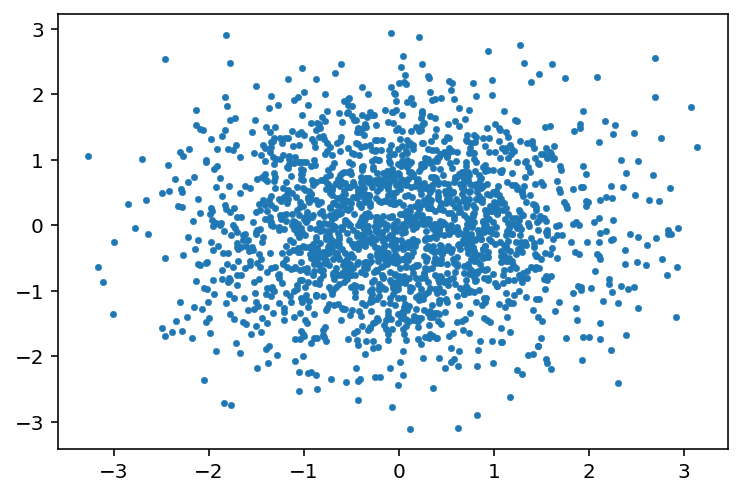

In [ ]:
#This whole notebook is under (re)construction.

In [126]:
# Select particle data file. 
# Eventually, this should be automated based on frame selection, but that also depends on frequency of particle outputs.
# For now it's manual.  Read the directory to choose your'step'. Its the sig figs in prt.*_000000.h5 files 


step = 36568 #corresponds to fld fram #20 in this case
rank=0

def read_particles(step):
    rank=0
    partfile = project_dir + f"/prt.{step:06d}_p{rank:06d}.h5"
    file = h5py.File(partfile, "r")
    particles = file["particles/p0/1d"]
    idx_begin = file["particles/p0/idx_begin"]
    idx_end = file["particles/p0/idx_end"]
    
    return particles, idx_begin, idx_end

    #df = pd.read_hdf(partfile, 'particles/p0/1d') #This would read all particles in the domain (a lot)

#step = 36568
#rank = 0
#df = pd.read_hdf(project_dir + f"/prt.{step:06d}_p{rank:06d}.h5", 'particles/p0/1d')
#df = read_particles(36568,0)
#particles, idx_begin, idx_end = read_particles(project_dir, 36568)

In [157]:

# Select a 2D box to read particles for dist function
lowleft = np.array([379,0,-1]) # Lower left corner of selection
topright = np.array([381,0,1]) # Lower right corner of selection


# Everything else in this cell below this line doesn't need user input.
# Just choose the dimensions and execute the cell





# Define a rectangle from selections
rectangle = plt.Rectangle((lowleft[0],lowleft[2]),topright[0]-lowleft[0], topright[2]-lowleft[2], fill=None,ec="k", lw=3)

# Function to shift to grid coordinates before selections
def select_region(sl,sh):
    il = ((sl - xl) / dx).astype(int)
    ih = ((sh - xl) / dx).astype(int)
    xl, xh, gdims, dx
    il -= np.array([1920,0,480])
    ih -= np.array([1920,0,480])
    return il, ih

# Field slicing (?)
def in_cell(*args):
    return slice(idx_begin[args], idx_end[args])

# Translate domain selection to proper coordinates to read particles
il,ih = select_region(lowleft,topright)

# Parse file to read particle data ONLY from selected region
cnt = 0
slices = []
for iz in range(il[2], ih[2]):
    for ix in range(il[0], ih[0]):
        for kind in range(2):
            r = in_cell(kind, iz, 0, ix)
            cnt += int(r.stop - r.start)
            slices.append(r)

s_min = min(s.start for s in slices)
s_max = max(s.stop for s in slices)
    
prt = particles[0]
prts = np.zeros(cnt, dtype=prt.dtype)
cnt = 0
for sl in slices:
    l = int(sl.stop - sl.start)
    prts[cnt:cnt+l] = particles[sl.start:sl.stop]
    cnt += l

    
# Make a dataframe with those particles, and divide it into ions and electrons     
df = pd.DataFrame(prts)
electrons = df[df.q<0]
ions = df[df.q>0]

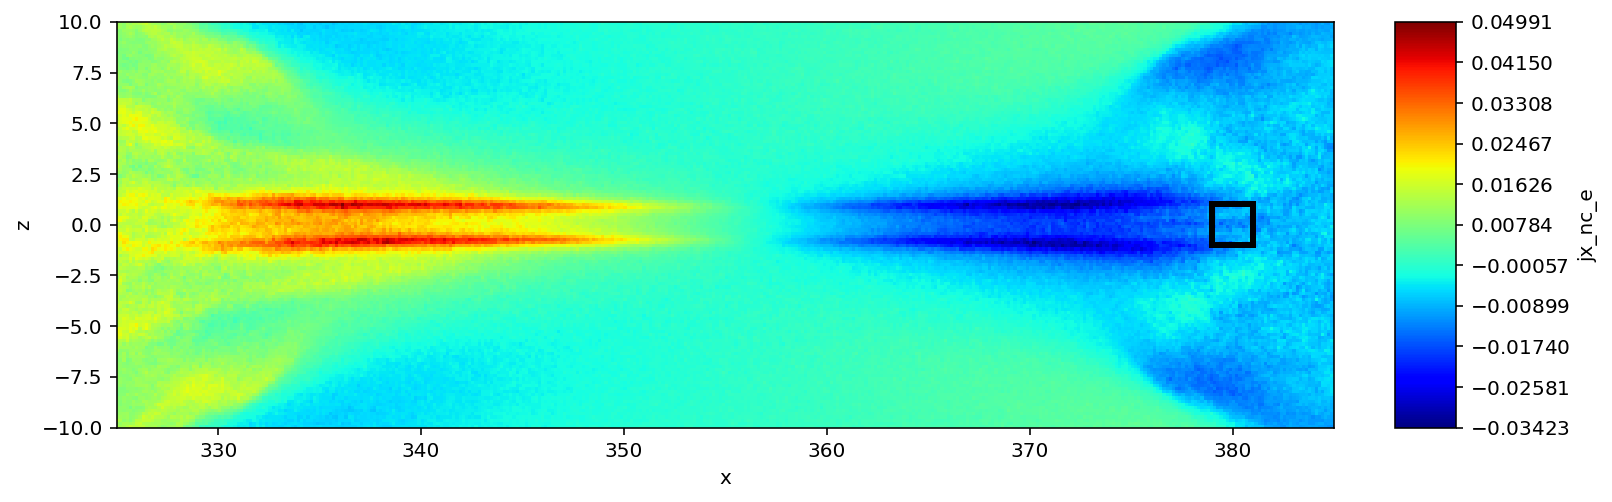

In [158]:
fig, ax = plt.subplots(figsize=(12, 5))
vlt.plot(vf["jx_nc_e"], selection="x=325f:385f,z=-10f:10f", ax=ax, cmap='jet')
plt.gca().add_patch(rectangle)



<AxesSubplot:xlabel='px', ylabel='py'>

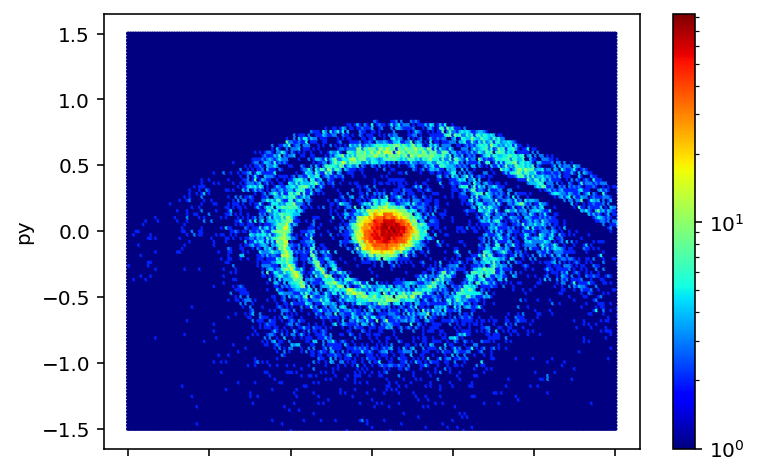

In [172]:
pmax = 1.5
kwargs = {"gridsize": 200, "extent": (-pmax, pmax, -pmax, pmax), "cmap": 'jet'}
electrons.plot.hexbin(x='px', y='py',bins="log",**kwargs)

In [ ]:
# VDF trimming methods. Box selection and arc selection. (untested)

# Inputs for box selection
# Define lower left and top right corners of a rectangular box
lowleft = np.array([-2,-2,-2])
topright = np.array([2,2,2])

# Inputs for arc selection
# Define [min,max] values for r, theta, phi 
pi = np.pi
r_bounds = np.array([0.1,1.5]) # Radius in velocity space. max of inf (r=2 will do for capturing basically everything)
theta_bounds = np.array([0,2*pi]) # Angle from px in the px,py plane.  max of 2pi
phi_bounds = np.array([0,pi]) # Angle from px in the px,pz plane. max of pi


# Make shapes to depict in velocity space
rectangle_xy = plt.Rectangle((lowleft[0],lowleft[1]),topright[0]-lowleft[0], topright[1]-lowleft[1], fill=None,ec="k", lw=3)
rectangle_xz = plt.Rectangle((lowleft[0],lowleft[2]),topright[0]-lowleft[0], topright[2]-lowleft[2], fill=None,ec="k", lw=3)
circle_out = plt.Circle((0,0), radius=r_bounds[1], fill=None,ec="k", lw=3)
circle_in = plt.Circle((0,0), radius=r_bounds[0], fill=None,ec="k", lw=3)
line_lowxy = plt.line2D((0,r_bounds[1]*np.cos(theta_bounds[0])*np.cos(phi_bounds[0])),(0,r_bounds[1]*np.sin(theta_bounds[0])),ec="k", lw=3)
line_lowxz = plt.line2D((0,r_bounds[1]*np.cos(theta_bounds[0])*np.cos(phi_bounds[0])),(0,r_bounds[1]*np.cos(theta_bounds[0])*np.sin(phi_bounds[0])),ec="k", lw=3)
line_hixy = plt.line2D((0,r_bounds[1]*np.cos(theta_bounds[1])*np.cos(phi_bounds[1])),(0,r_bounds[1]*np.sin(theta_bounds[1])),ec="k", lw=3)
line_hixz = plt.line2D((0,r_bounds[1]*np.cos(theta_bounds[1])*np.cos(phi_bounds[1])),(0,r_bounds[1]*np.cos(theta_bounds[1])*np.sin(phi_bounds[1])),ec="k", lw=3)


def box_trim(lowleft, topright):
    selection = electrons[electrons.px>lowleft[0] & electrons.px<topright[0]]
    selection = selection[selection.py>lowleft[1] & selection.py<topright[1]]
    selection = selection[selection.pz>lowleft[2] & selection.pz<topright[2]]
    
    return selection


def arc_trim(r,theta,phi):
    electrons['r'] = np.sqrt(electrons['px']**2 + electrons['py']**2 + electrons['pz']**2)
    electrons['theta'] = np.arcsin(electrons['px']/np.sqrt(electrons['px']**2 + electrons['py']**2))
    electrons['phi'] = np.arccos(electrons['px']/np.sqrt(electrons['px']**2 + electrons['pz']**2))
    
    selection = electrons[electrons.r > r[0] & electrons.r < r[1]]
    selection = selection[selection.theta > theta[0] & selection.theta < theta[1]]
    selection = selection[selection.phi > phi[0] & selection.phi < phi[1]]
    
    return selection
    


plt.gca().add_patch(rectangle)


    
trim = arc_trim(r_bounds,theta_bounds,phi_bounds)

#trim = box_trim(lowleft, topright)


trim.head()

In [ ]:
# Later: Distill selection to managable ensemble.  Could be done in 2 different ways:
    # 1) Arrange df by energy, select median particle and however many quartiles desired
    # 2) Randomly distribute points within selection region (NOT a dataframe selection.  A random scatter within the bounds)

In [ ]:
# Later: Set up the pushing algorithm to feed ensemble into. Push forward and backward in time.  
# Later: Track various quantities of interest:
    # Particle position, velocity,energy (already built-in to Push code), parallel & perpendicular velocities&energies
    # Total ensemble energy, bulk & random components
    # Parallel vs perp ensemble energy (might be useful. Its easily calculable)
# Later: Allow for color coding individual trajectories based on energy

# Much later: Time evolving fields. Should be built directly into the Push code.
    # At each step, particle experiences a weighted average of fields from frame_i and frame_i+1 (linear interpolation in time)
    # if electron is 50% thru its journey to the next frame, then the B it experiences is 0.5*B_old + 0.5*B_new
    # if electron is 25% thru its journey, then it experiences 0.75*B_old + 0.25*B_new
    # the factors outside B_old,new (and E's) will be calculated based on the number of steps, duration of steps, etc
        # will need to think about how the elapsed 'time' in the push relates to the frame times
    # to handle continuation beyond frame_i+1, 2 potential options:
        # Rolling weights. All frames are included & weighted
            # ex: if electron is 25% past frame_i+1 then B = 0*Bi + 0.75*B_i+1 + 0.25*B_i+2 + 0*B_i+3 + 0*B_i+4 ....
        # Some kind of conditional statement to keep track of when a frame time has been crossed and update field_i and i+1
        #... I kinda like the rolling weights idea, but its TBD how efficient/easy it would be

# Anything else??

In [ ]:
# Everything below here is old

In [5]:
# Choose timestep, find prt file for that timestep in the directory 
t = 17
import os
dirlist = os.listdir(dir)
dirlist = [x for x in dirlist if "prt" in x ]


#This defines the variable ThePrt: a 5 or 6 digit number indicating
#the timestep in the particle output file
if dirlist[t][:5] == 'prt.1':
    ThePrt = int(dirlist[t][4:10]) 
else:
    ThePrt = int(dirlist[t][5:10])

#Read_Particles will force the 2nd argument to be 6 digits anyway, 
# so if ThePrt = 95069 read particles automatically matches the prt format
# with 095069
particles, idx_begin, idx_end = read_particles(dir, ThePrt)
#This defines the variable ThePrt: a 5 or 6 digit number indicating
#the timestep in the particle output file

#particles, idx_begin, idx_end = read_particles(dir, 36568)
ThePrt

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not builtin_function_or_method

In [7]:
particles, idx_begin, idx_end = read_particles(project_dir, 36568)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '~/harris_run/prt.036568_p000000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
# Choose boundaries within domain to read in particle data
sl = np.array([746,0,-5])
sh = np.array([758,0,5])

il = ((sl - xl) / dx).astype(int)
ih = ((sh - xl) / dx).astype(int)

particle_start = np.array([3840, 0, 960])
particle_count = np.array([idx_begin.shape[3], idx_begin.shape[2], idx_begin.shape[1]])


def in_cell(kind, iz, iy, ix):
    loc = kind, iz - particle_start[2], iy - particle_start[1], ix - particle_start[0]
    return slice(idx_begin[loc], idx_end[loc])
cnt = 0
slices = []
for iz in range(il[2], ih[2]):
    for ix in range(il[0], ih[0]):
        for kind in range(2):
            r = in_cell(kind, iz, 0, ix)
            cnt += int(r.stop - r.start)
            slices.append(r)
        
s_min = min(s.start for s in slices)
s_max = max(s.stop for s in slices)

prt = particles[0]
prts = np.zeros(cnt, dtype=prt.dtype)
cnt = 0
for sl in slices:
    l = int(sl.stop - sl.start)
    prts[cnt:cnt+l] = particles[sl.start:sl.stop]
    cnt += l
    
    
df = pd.DataFrame(prts)
vf = viscid.load_file(run, force_reload=True)
#vf.activate_time(17)
df[df.q<1].head()

x         y         z        px        py        pz    q    m  \
0  745.983337 -8.984365 -4.906219  0.449052  0.272118 -0.112537 -1.0  1.0   
1  745.966064 -9.977851 -4.954849  0.420526  0.243428 -0.136581 -1.0  1.0   
2  745.982544 -0.050103 -4.887405  0.467821 -0.375438  0.065506 -1.0  1.0   
3  745.989929 -9.604767 -4.866241  0.353219 -0.478142 -0.224625 -1.0  1.0   
4  745.954346  1.481825 -4.920212  0.399043 -0.204158 -0.110959 -1.0  1.0   

          w  
0  0.000333  
1  0.000333  
2  0.000333  
3  0.000333  
4  0.000333

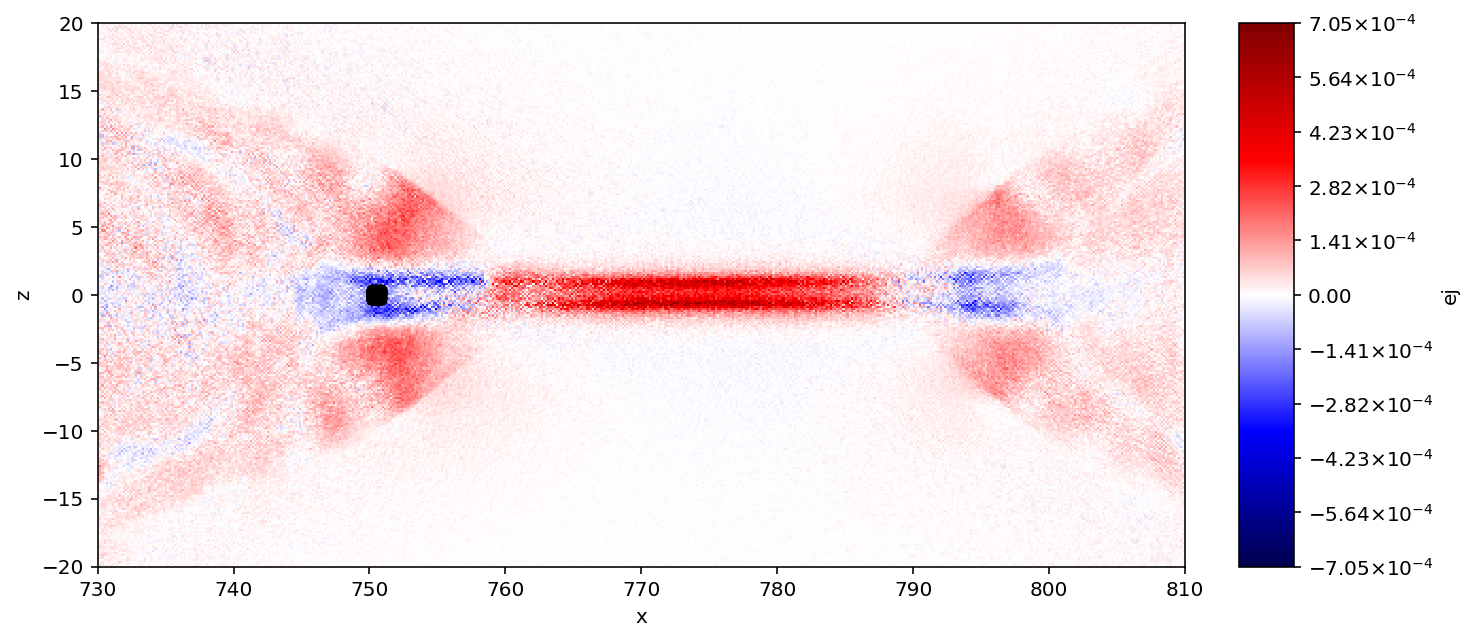

In [8]:

# Choose the center of a 1x1 region of interest
region = np.array([750.5,0])

# Choose timestep, limit to electrons only, and choose x and z limits to plot 
vf.activate_time(17)
electrons = df[df.q < 0]
selection = "x=730f:810f, z=-20f:20f"

# Only selects electrons within 1x1 region 
s_x0 = (electrons.x >= region[0] - 0.4) & (electrons.x <= region[0] + 0.4)
s_y0 = (electrons.z >= region[1] - 0.4) & (electrons.z <= region[1] + 0.4)


# Plot setup
fig, ax = plt.subplots(figsize=(12, 5))
vlt.plot(vf["ej = jx_nc_e*ex_ec + jy_nc_e*ey_ec + jz_nc_e*ez_ec"],symmetric=True, selection=selection, ax=ax, cmap='seismic')
electrons[s_x0 & s_y0].iloc[::10].\
    plot.scatter(x="x", y="z", c="k", ax=ax, alpha=1, colorbar=None)
ax.set_aspect("equal")

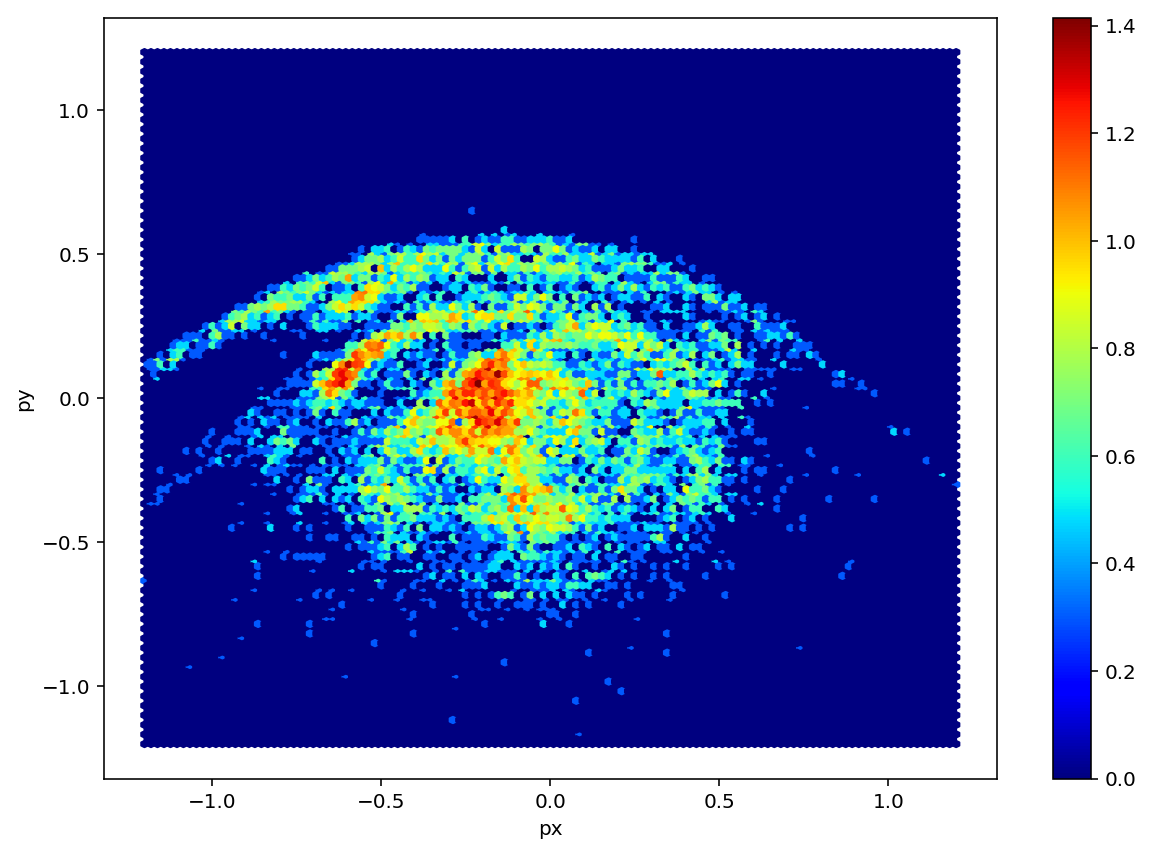

In [9]:
# Plot a vdf from the chosen 1x1 region 
kwargs = {"gridsize": 125, "extent": (-1.2, 1.2, -1.2, 1.2), "cmap": 'jet'}
fig, ax = plt.subplots(1, 1, figsize=(10,7))

electrons[s_y0 & s_x0].plot.hexbin(x='px', y='py', bins="log", ax=ax, **kwargs)



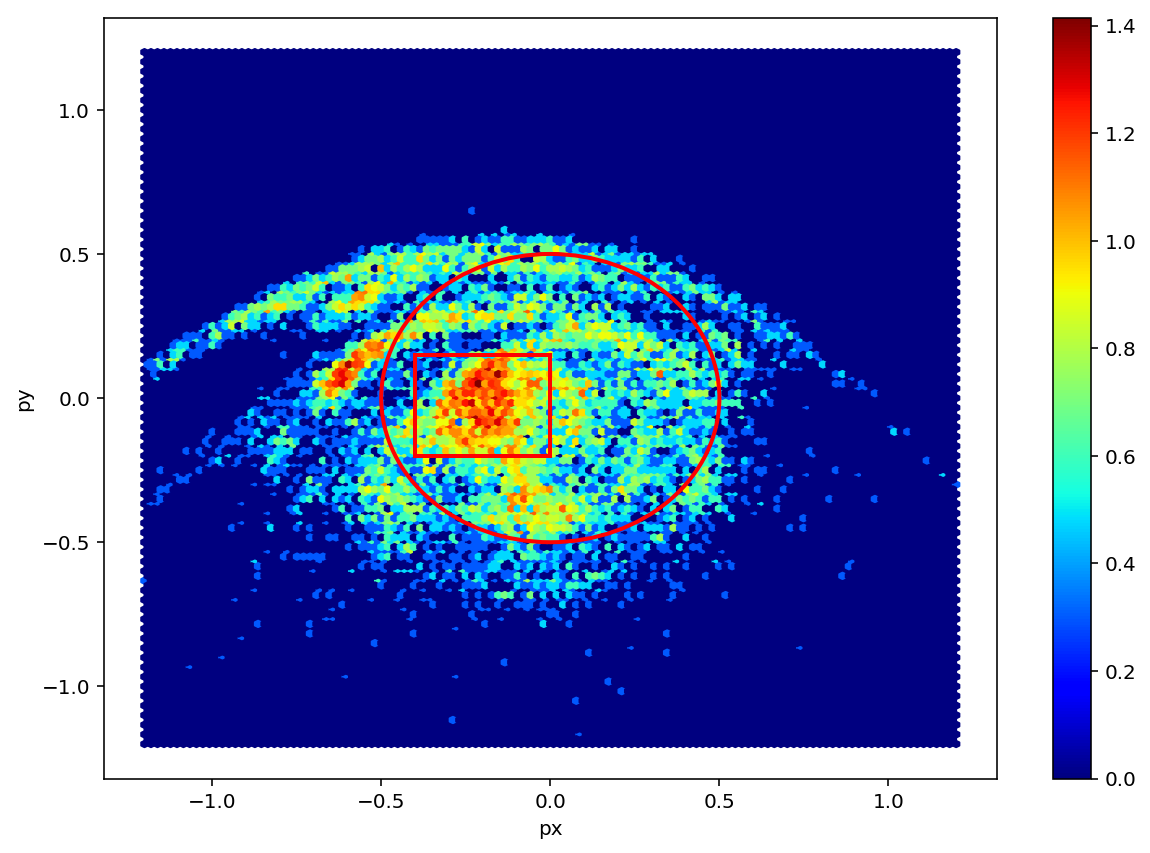

In [10]:
### Particle Selection Criteria


df = pd.DataFrame(prts)
import matplotlib.patches as patches


## Spatial Selection 
# Restricting sample to small region chosen
# Can these 4 lines be made more concise?
df = df.loc[lambda df: df["x"] < region[0] + 0.4] 
df = df.loc[lambda df: df["x"] > region[0] - 0.4]
df = df.loc[lambda df: df["z"] < region[1] + 0.4] 
df = df.loc[lambda df: df["z"] > region[1] - 0.4]




## Circular Selection
# Choose the radii(in momentum space) of two circles and only select from particles between them  
# so far this is only for px-py, but its easy enough to do it for another plane.  


rl = 0.5
rs = 0
df['r'] = (df['px']**2 + df['py']**2)**0.5
    
df = df.loc[lambda df: df['r'] < rl]
df = df.loc[lambda df: df['r'] > rs]
    


kwargs = {"gridsize": 125, "extent": (-1.2, 1.2, -1.2, 1.2), "cmap": 'jet'}
fig, ax = plt.subplots(1, 1, figsize=(10,7))

circle1 = plt.Circle((0,0),rs, color = 'black', fill = True)
circle2 = plt.Circle((0,0),rl, linewidth = 2,color = 'red', fill = False)




## Box Selection 
# Choose bounds (in momentum space) within which particles will be considered
x_range = [-0.4,0]
y_range = [-0.2,0.15]
z_range = [-1,1]

df = df.loc[lambda df: df['px'] > x_range[0]]
df = df.loc[lambda df: df['px'] < x_range[1]]
df = df.loc[lambda df: df['py'] > y_range[0]]
df = df.loc[lambda df: df['py'] < y_range[1]]
#df = df.loc[lambda df: df['pz'] > z_range[0]]
#df = df.loc[lambda df: df['pz'] < z_range[1]]


diff_x = x_range[1] - x_range[0]
diff_y = y_range[1] - y_range[0]
diff_z = z_range[1] - z_range[0]

rect = patches.Rectangle((x_range[0],y_range[0]),diff_x,diff_y,linewidth=2,edgecolor='r',facecolor='none')






electrons[s_y0 & s_x0].plot.hexbin(x='px', y='py', bins="log", ax=ax, **kwargs)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_patch(rect)


In [11]:
df = pd.DataFrame(prts)

df['eng_sqrd'] = (df['px']**2 + df['py']**2 + df['pz']**2)
    
min = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].min()]
med = df.loc[lambda df: df["eng_sqrd"] == df["eng_sqrd"].median()]
max = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].max()]


test = df['eng_sqrd'].median()

test2 = df.loc[df["eng_sqrd"] == 0.009312499314546585]

#m = df.loc[:,'eng_sqrd'].median()
#med = df.loc[lambda df: df['px'] == df['px'].median()]

#medd = df.loc[lambda df:df["eng_sqrd"] == df.loc[:,"eng_sqrd"].median()]

#med = df.loc[lambda df: df["eng_sqrd"] > 0.3232147693633]
#medd = med.loc[lambda med: med["eng_sqrd"] < 0.3232147693635]
#medd = minmed.loc[lambda df: minmed['eng_sqrd'] == minmed["eng_sqrd"].median()]
    
#df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].median]
#df["eng_sqrd"].max()
#df['eng_sqrd'].median()


In [12]:





# Chooses 5 particles that vary from lowest to highest energy 
def Particle_Select3():
    df['eng_sqrd'] = (df['px']**2 + df['py']**2 + df['pz']**2)
    
    min = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].min()]
    med = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].median()]
    max = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].max()]
    
    minmed = df.loc[lambda df: df['eng_sqrd'] < df["eng_sqrd"].median()]
    minmed = minmed.loc[lambda df: minmed['eng_sqrd'] == minmed["eng_sqrd"].median()]
    
    medmax = df.loc[lambda df: df['eng_sqrd'] > df["eng_sqrd"].median()]
    medmax = medmax.loc[lambda df: medmax['eng_sqrd'] == medmax["eng_sqrd"].median()]
    
    r_min = np.array([min["x"].median(),min["y"].median(),min["z"].median()])
    p_min = np.array([min["px"].median(),min["py"].median(),min["pz"].median()])
    
    r_minmed = np.array([minmed["x"].median(),minmed["y"].median(),minmed["z"].median()])
    p_minmed = np.array([minmed["px"].median(),minmed["py"].median(),minmed["pz"].median()])
    
    r_med = np.array([med["x"].median(),med["y"].median(),med["z"].median()])
    p_med = np.array([med["px"].median(),med["py"].median(),med["pz"].median()])
    
    r_medmax = np.array([medmax["x"].median(),medmax["y"].median(),medmax["z"].median()])
    p_medmax = np.array([medmax["px"].median(),medmax["py"].median(),medmax["pz"].median()])
    
    r_max = np.array([max["x"].median(),max["y"].median(),max["z"].median()])
    p_max = np.array([max["px"].median(),max["py"].median(),max["pz"].median()])

    #return r_min, r_minmed, r_med, r_medmax, r_max, p_min, p_minmed, p_med, p_medmax, p_max, 
    return r_min, r_med, r_max, p_min, p_med, p_max, 


#r0,r1,r2,r3,r4,p0,p1,p2,p3,p4 = Particle_Select()
r0,r1,r2,p0,p1,p2 = Particle_Select3()



# Cross product 
def VxB(v,B):
    x_comp = v[1]*B[2] - v[2]*B[1]
    y_comp = v[2]*B[0] - v[0]*B[2]
    z_comp = v[0]*B[1] - v[1]*B[0]
    
    vxb = np.array([x_comp, y_comp, z_comp])
    return vxb

# Interpolate 
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]

# Retrieve field values at a given position in the simulation domain
def Get_Fields(r):
    Ex, Ey, Ez = vf['ex_ec'], vf['ey_ec'], vf['ez_ec']
    Bx, By, Bz = vf['hx_fc'], vf['hy_fc'], vf['hz_fc']
    
    r = np.array([r[0],0,r[2]]) # This Resets the y position to zero
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B

# Boris particle push
def Push(r0,p0,n):
    #Define position (r) & momentum (p) 
    r = np.zeros((n+1,3))
    p = np.zeros((n+1,3))
    
    #Initial r & p
    r[0] = r0
    p[0] = p0
    
    for i in range(n):

            E, B = Get_Fields(r[i])

            # Convenient rotation vector 
            b_rot = q*B*dt/2*m

            # 1st half of electric push
            p_1 = p[i] + q*E*dt/2

            # Rotation by VxB
            p_2 = p_1 + 2*VxB((p_1 + VxB(p_1,b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)

            # 2nd half of electric push 
            p[i+1] = p_2 + q*E*dt/2
            r[i+1] = r[i] + p[i+1]*dt/m
    
    
    
    
    return r,p


array([-0.38475513, -0.18031846, -0.99580634])

In [13]:

# Set mass(m), charge(q), timestep(dt), and number of timesteps(n) 
m = 1
q = -1
dt = -0.5
n = 500

# Push the particle
r,p = Push(r0,p0,n)
r2,p2 = Push(r2,p2,n)
#r2,p2 = Push(r2,p2,n)
#r3,p3 = Push(r3,p3,n)
#r4,p4 = Push(r4,p4,n)



(-40, 40)

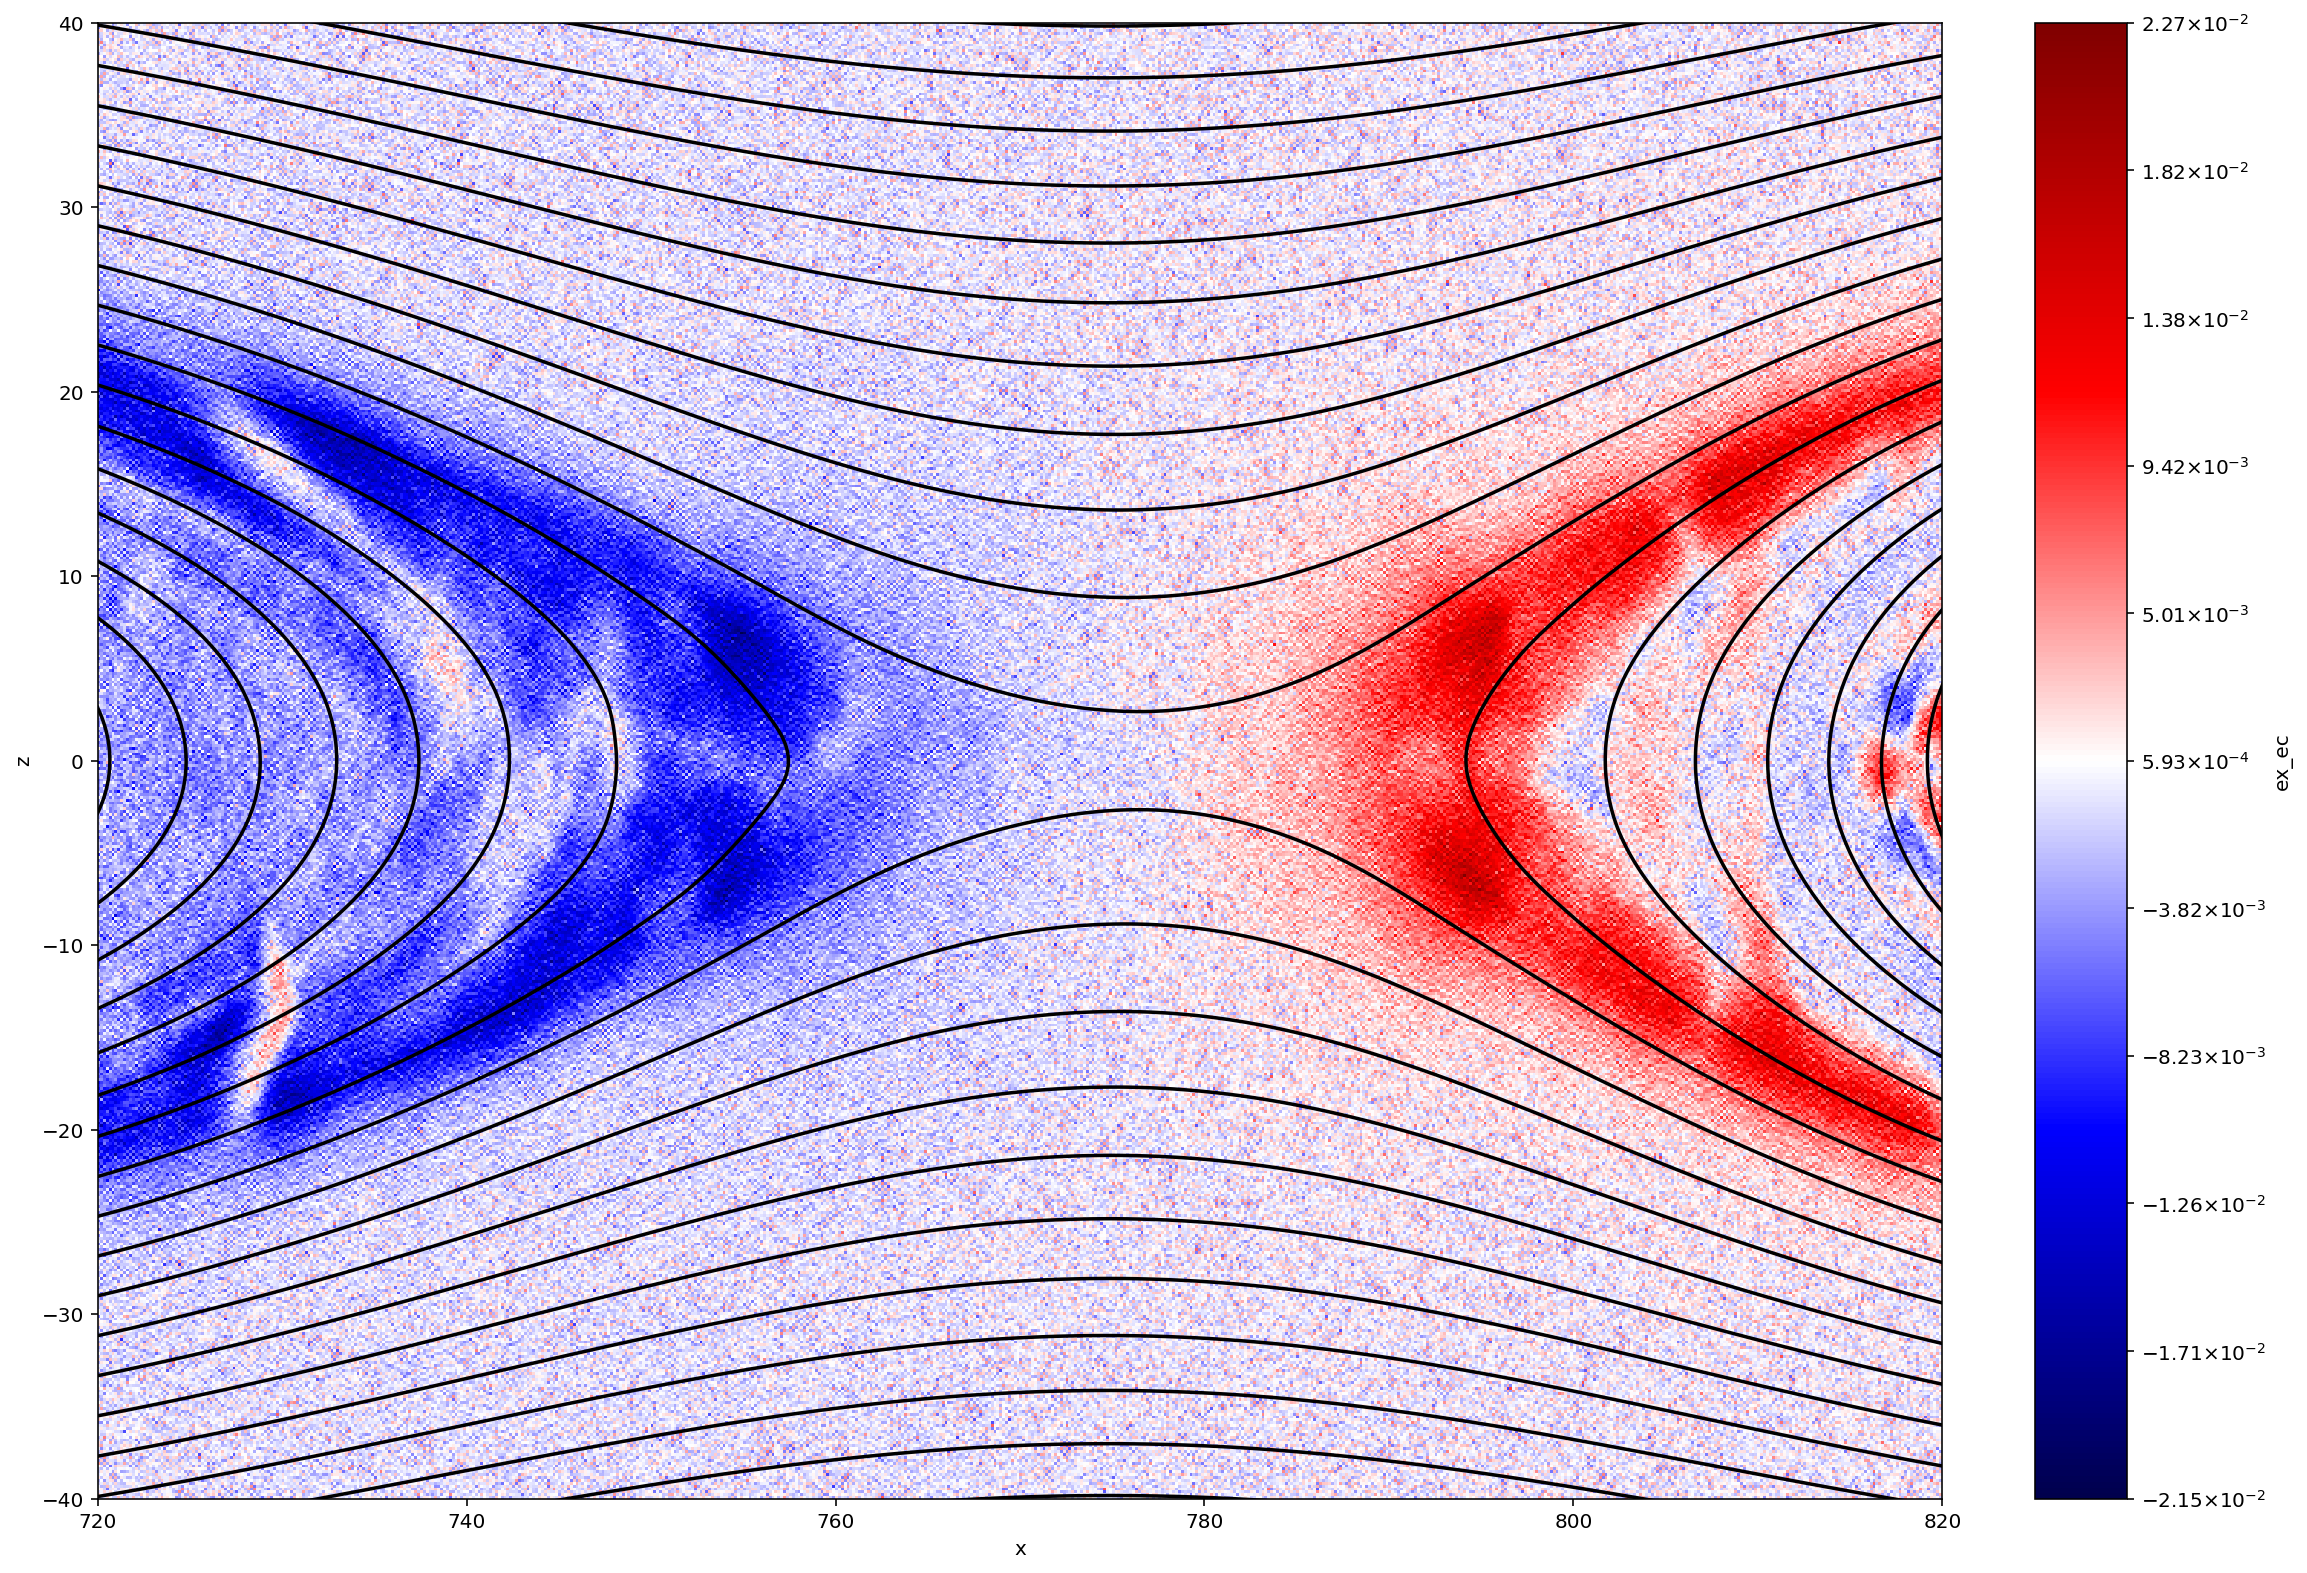

In [18]:
fld = "ex_ec"
vf.activate_time(17)

# Plot setup
plt.figure(figsize=(40,16))
plt.subplot(1,2,1)
vlt.plot(vf[fld], cmap = "seismic")
vlt.plot(vf["psi"],style="contour",levels=100,colors='black');
plt.axis("image")
plt.xlim(720,820)
plt.ylim(-40,40)


MemoryError: 

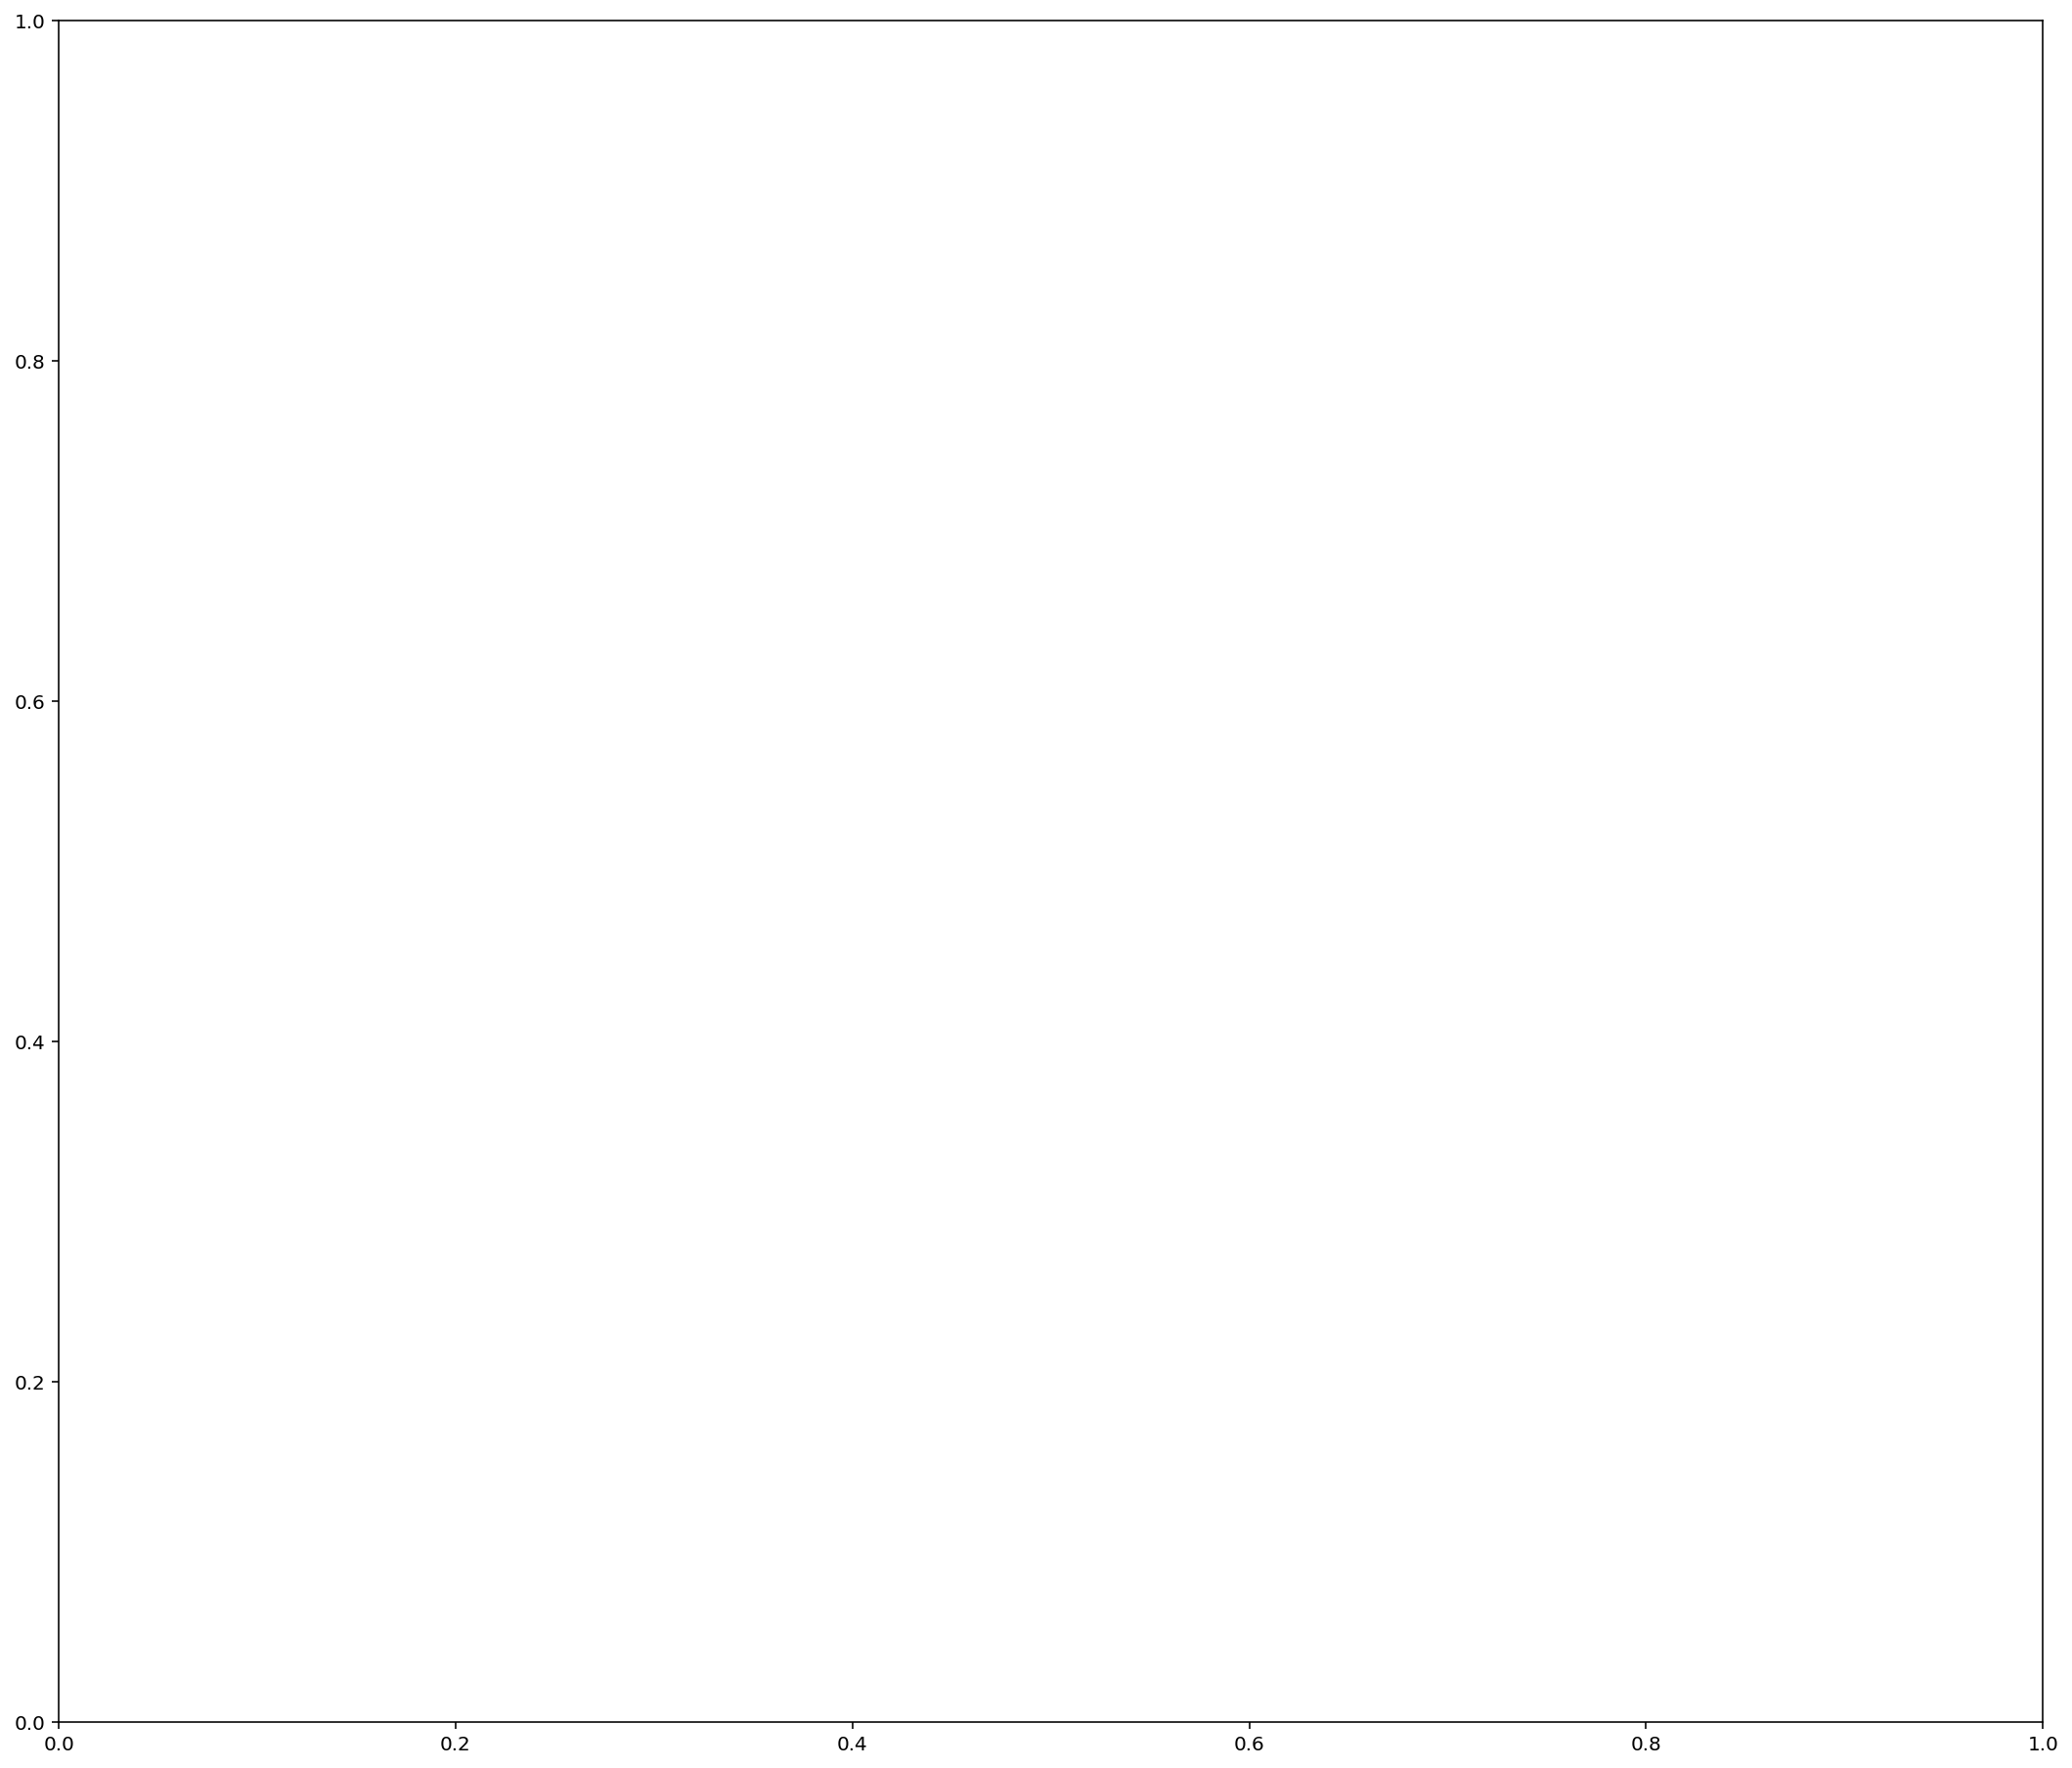

In [66]:
# Choose fld parameter to plot and timestep to use
fld = "ej_e=(jx_nc_e*ex_ec + jy_nc_e*ey_ec + jz_nc_e*ez_ec)"
fld = "rho_nc_e"

vf.activate_time(17)

# Plot setup
plt.figure(figsize=(40,16))
plt.subplot(1,2,1)
vlt.plot(vf[fld], cmap = "seismic")
vlt.plot(vf["psi"],style="contour",levels=100,colors='black');
plt.axis("image")
plt.xlim(720,820)
plt.ylim(-40,40)

# Plot x-z trajectory over the fld 
plt.plot(r[:,0],r[:,2], 'red')
#plt.plot(r4[:,0],r4[:,2], 'blue')
plt.plot(r2[:,0],r2[:,2], 'blue')
#plt.plot(r3[:,0],r3[:,2], 'black')





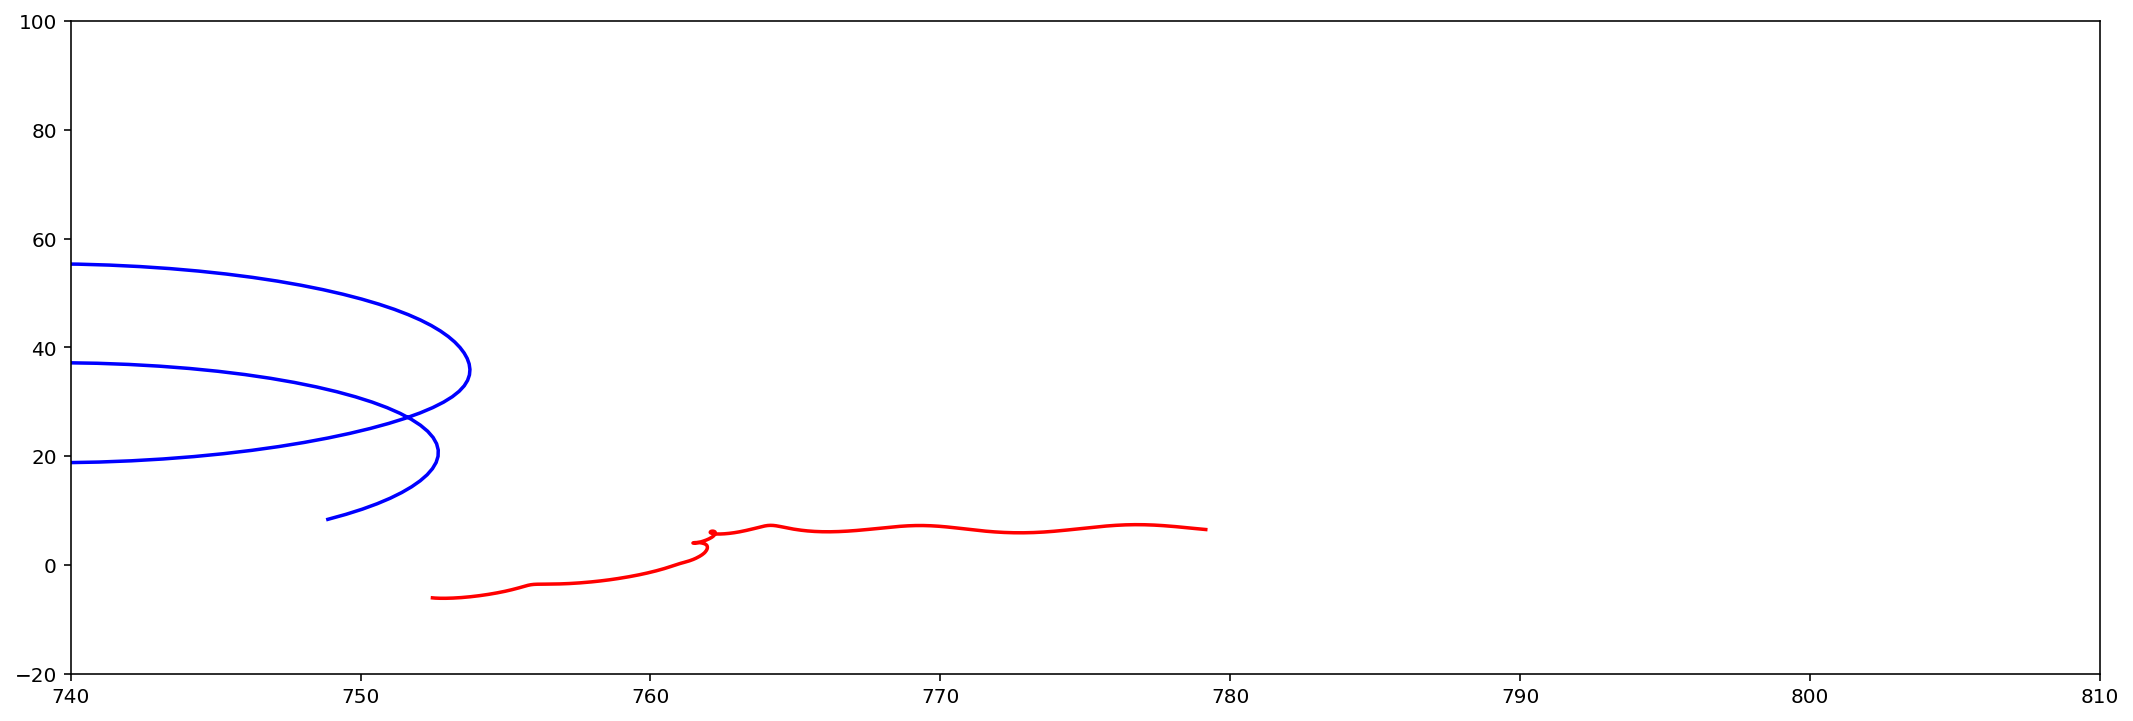

In [58]:
# Plot x-y trajectory
plt.figure(figsize=(40,6))
plt.subplot(1,2,1)
plt.xlim(740,810)
plt.ylim(-20,100)
plt.plot(r[:,0],r[:,1], 'red')
#plt.plot(r1[:,0],r1[:,1], 'blue')
plt.plot(r2[:,0],r2[:,1], 'blue')
